<a href="https://colab.research.google.com/github/DmitrijLeontev/Dmitrij_Leontev/blob/main/DzDatascience/%D0%94%D0%97_UltraPro2_%D0%A1%D0%B2%D0%B5%D1%80%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D0%B5_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Используя базу данных автомобилей, создайте сеть с точностью распознавания не ниже 93% на проверочной выборке.

Для решения задачи вы можете использовать любой подход:
- модель без аугментации данных
- аугментация данных с помощью ImageDataGenerator
- аугментация данных с помощью самописного генератора изображений
- использовать готовую архитектуру из набора `tf.keras.applications` (Обратите внимание: на занятии мы не рассматривали данный модуль фреймворка Керас. Ваша задача: попробовать самостоятельно разобраться в приципах его работы. В разборе домашнего задания вы получите ссылку на ноутбук Базы Знаний УИИ, где подробно раскрывается вопрос использования готовых архитектур)

In [ ]:
# Ваше решение
# Подключение модуля для загрузки данных из облака
import gdown

# Загрузка zip-архива с датасетом из облака на диск виртуальной машины colab
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l5/middle_fmr.zip', None, quiet=True)

'middle_fmr.zip'

In [ ]:
# Разархивация датасета в директорию 'content/cars'
!unzip -qo "middle_fmr.zip" -d /content/cars

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = '/content/cars/'

Теперь вы можете увидеть, что находится в загруженной базе. Для этого функцией listdir() из модуля os получите список папок по адресу IMAGE_PATH:

In [ ]:
# Для работы с файлами
import os

os.listdir(IMAGE_PATH)

['Ferrari', 'Renault', 'Mercedes']

In [ ]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 3, метки классов: ['Ferrari', 'Mercedes', 'Renault']


Аналогично, вы можете обратиться уже к каждой папке, чтобы получить имена файлов в них. Для этого соберите вместе путь до папки и имя папки:

In [ ]:
i = 1

# Формирование пути к выборке одной марки авто
f'{IMAGE_PATH}{CLASS_LIST[i]}/'

'/content/cars/Mercedes/'

In [ ]:
# Теперь можно получить списки файлов для всех классов
for cls in CLASS_LIST:
    print(cls, ':', os.listdir(f'{IMAGE_PATH}{cls}/'))

Ferrari : ['car_Ferrari__981.png', 'car_Ferrari__809.png', 'car_Ferrari__1285.png', 'car_Ferrari__706.png', 'car_Ferrari__150.png', 'car_Ferrari__332.png', 'car_Ferrari__64.png', 'car_Ferrari__760.png', 'car_Ferrari__560.png', 'car_Ferrari__625.png', 'car_Ferrari__635.png', 'car_Ferrari__603.png', 'car_Ferrari__552.png', 'car_Ferrari__555.png', 'car_Ferrari__110.png', 'car_Ferrari__1188.png', 'car_Ferrari__1150.png', 'car_Ferrari__1028.png', 'car_Ferrari__722.png', 'car_Ferrari__848.png', 'car_Ferrari__772.png', 'car_Ferrari__881.png', 'car_Ferrari__218.png', 'car_Ferrari__1287.png', 'car_Ferrari__1049.png', 'car_Ferrari__1260.png', 'car_Ferrari__452.png', 'car_Ferrari__123.png', 'car_Ferrari__401.png', 'car_Ferrari__290.png', 'car_Ferrari__43.png', 'car_Ferrari__585.png', 'car_Ferrari__258.png', 'car_Ferrari__302.png', 'car_Ferrari__208.png', 'car_Ferrari__819.png', 'car_Ferrari__254.png', 'car_Ferrari__300.png', 'car_Ferrari__446.png', 'car_Ferrari__280.png', 'car_Ferrari__234.png', 

Отобразим визуально для примера по одному изображению из каждого класса (при помощи функции imshow() из модуля matplotlib.pyplot).

Для этого импортируем необходимые библиотеки, создадим заготовку для изображений всех классов.

Далее в цикле переберем все классы. Сформируем путь к классу, выберем из него один случайный экземпляр (при помощи функции random.choice()) и отобразим его в ячейке (получим содержимое картинки при помощи функции open() из модуля Image).

In [ ]:
from PIL import Image                     # Отрисовка изображений
import random                             # Генерация случайных чисел
import matplotlib.pyplot as plt           # Отрисовка графиков

%matplotlib inline

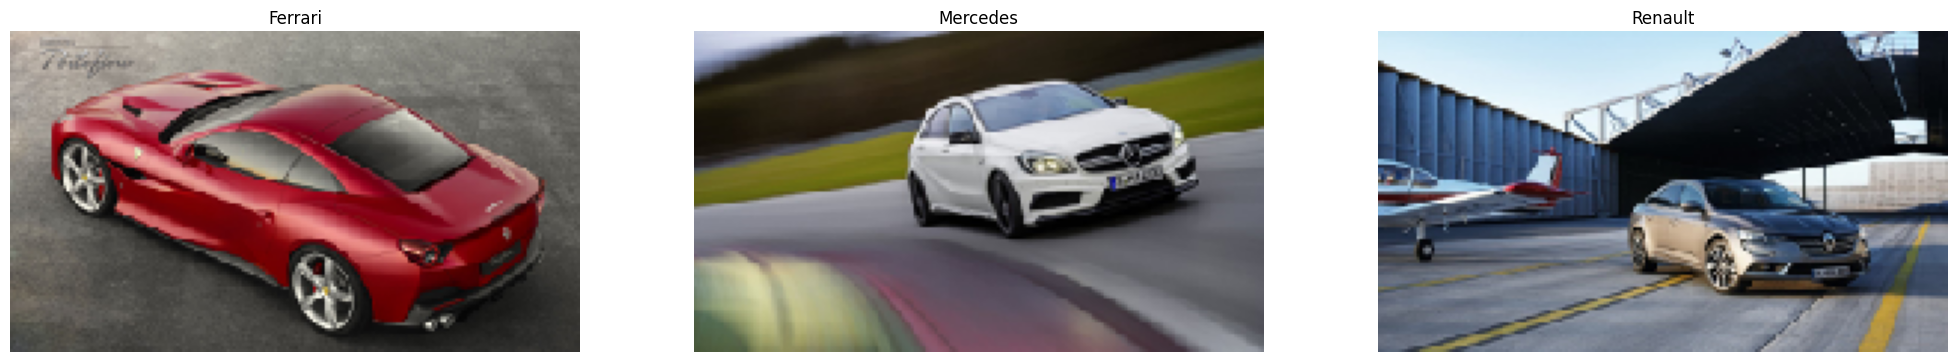

In [ ]:
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(25, 5))

# Для всех номеров классов:
for i in range(CLASS_COUNT):
    # Формирование пути к папке содержимого класса
    car_path = f'{IMAGE_PATH}{CLASS_LIST[i]}/'
    # Выбор случайного фото из i-го класса
    img_path = car_path + random.choice(os.listdir(car_path))
    # Отображение фотографии (подробнее будет объяснено далее)
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

Создание списков файлов и их меток класса Чтобы создать обучающую базу, вам понадобится список всех картинок машин, а также список номеров (меток) класса для них в том же порядке. То есть, например, для пятого по порядку файла в списке файлов метка его класса будет пятой в списке меток.

Сейчас фотографии машин каждого класса лежат в отдельных папках. Загружая фотографию машины, вы можете сразу записывать порядковый номер папки как метку класса машины в соответствующий список.

Количество классов равно CLASS_COUNT – уже было вычислено ранее.

По аналогии с тем, как выше осматривалось содержимое папок, вы можете, получив имена файлов фотографий, собрать их в список data_files, а в список data_labels - собрать номера (метки) классов один за другим:

In [ ]:
data_files = []                           # Cписок путей к файлам картинок
data_labels = []                          # Список меток классов, соответствующих файлам

for class_label in range(CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = IMAGE_PATH + class_name  # Формирование полного пути к папке с изображениями класса
    class_files = os.listdir(class_path)  # Получение списка имен файлов с изображениями текущего класса
    print(f'Размер класса {class_name} составляет {len(class_files)} машин')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print('Общий размер базы для обучения:', len(data_labels))

Размер класса Ferrari составляет 1088 машин
Размер класса Mercedes составляет 1161 машин
Размер класса Renault составляет 1178 машин
Общий размер базы для обучения: 3427


In [ ]:
# Теперь в списках находятся пути к файлам и соответствующие им номера классов:
print('Пути к файлам: ', data_files[1085:1090])
print('Их метки классов:', data_labels[1085:1090])

Пути к файлам:  ['/content/cars/Ferrari/car_Ferrari__1.png', '/content/cars/Ferrari/car_Ferrari__1251.png', '/content/cars/Ferrari/car_Ferrari__450.png', '/content/cars/Mercedes/car__943.png', '/content/cars/Mercedes/car__771.png']
Их метки классов: [0, 0, 0, 1, 1]


Формирование набора данных из имеющейся базы

В результате выполнения кода получились два списка:

data_files - имена файлов картинок из датасета; data_labels - метки (номера) классов, соответствующие файлам картинок из первого списка. С их помощью можно сформировать набор для обучения.

Теперь вы можете использовать список путей к файлам для формирования списка уже самих картинок, преобразованных в массивы пикселей. Это можно сделать функцией np.array(). Предварительно, загрузив фотографии методом Image.open(), примените метод .resize(). Это необходимо, чтобы все фотографии, а значит, и массивы пикселей, были одного размера. Приведение всех картинок к одному общему размеру поможет собрать единый массив из всего датасета.

Импортируем необходимую библиотеку, задаем желаемые размеры изображений, подготавливаем пустой список. Схема действий следующая:

перебираем в цикле пути к файлам изображений; открываем каждое изображение; приводим изображение к заданному размеру; переводим изображение в числовой формат; присоединяем полученный массив к общему списку; переводим общий список изображений в numpy-массив; переводим общий список меток классов в numpy-массив.

In [ ]:
# Задание единых размеров изображений

IMG_WIDTH = 128                           # Ширина изображения
IMG_HEIGHT = 64                           # Высота изображения

In [ ]:
import numpy as np                        # Библиотека работы с массивами

data_images = []                          # Пустой список для данных изображений

for file_name in data_files:
    # Открытие и смена размера изображения
    img = Image.open(file_name).resize((IMG_WIDTH, IMG_HEIGHT))
    img_np = np.array(img)                # Перевод в numpy-массив
    data_images.append(img_np)            # Добавление изображения в виде numpy-массива к общему списку

x_data = np.array(data_images)            # Перевод общего списка изображений в numpy-массив
y_data = np.array(data_labels)            # Перевод общего списка меток класса в numpy-массив

print(f'В массив собрано {len(data_images)} фотографий следующей формы: {img_np.shape}')
print(f'Общий массив данных изображений следующей формы: {x_data.shape}')
print(f'Общий массив меток классов следующей формы: {y_data.shape}')

В массив собрано 3427 фотографий следующей формы: (64, 128, 3)
Общий массив данных изображений следующей формы: (3427, 64, 128, 3)
Общий массив меток классов следующей формы: (3427,)


Вы перевели изображения в тензоры, давайте посмотрим, в каком виде они сейчас хранятся в памяти, обратившись к первому из них по индексу:

array([[[220, 227, 230],
        [225, 229, 234],
        [229, 232, 236],
        ...,
        [ 33,  41,  31],
        [ 44,  56,  37],
        [ 45,  54,  37]],

       [[224, 228, 233],
        [227, 231, 235],
        [229, 235, 235],
        ...,
        [ 47,  57,  39],
        [ 61,  64,  46],
        [ 59,  62,  43]],

       [[225, 229, 233],
        [228, 232, 234],
        [229, 235, 235],
        ...,
        [ 47,  59,  39],
        [ 81,  73,  54],
        [ 68,  70,  48]],

       ...,

       [[101,  96,  92],
        [110, 104,  99],
        [112, 108, 100],
        ...,
        [149, 144, 139],
        [148, 144, 138],
        [140, 135, 129]],

       [[ 99,  96,  90],
        [105, 100,  95],
        [106, 101,  96],
        ...,
        [142, 137, 131],
        [137, 132, 127],
        [129, 125, 119]],

       [[107, 104,  99],
        [111, 107, 103],
        [112, 108, 102],
        ...,
        [110, 102,  94],
        [105,  98,  91],
        [ 98,  92,  86]]], dtype=uint8)
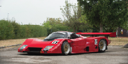

In [ ]:
x_data[0]

Заметим, что это трехмерные тензоры. В каждой ячейке стоит значение интенсивности пикселя в диапазоне 0-255. Для лучшего обучения нейронной сети данные необходимо перевести в диапазон [0, 1].

Такая операция называется нормализацией (нормированием) данных. Есть разные способы, а в данном случае нам подойдет деление всех значений на 255. Это число является максимумом исходного диапазона, поэтому любое значение пикселя, разделенное на него, даст результат от 0 до 1.

In [ ]:
# Нормированние массива изображений
x_data = x_data / 255.

In [ ]:
# Подключение нужных слоев из модуля tensorflow.keras.layers

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation
from tensorflow.keras.layers import Dropout, BatchNormalization
from keras import backend as K


In [ ]:
# Создание модели последовательной архитектуры
model = Sequential()

# Первый сверточный блок
model.add(Conv2D(256, (3, 3), name='First_C', padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))  # (64,128,3) --> (64,128,256) меняется кол-во фильтров
model.add(BatchNormalization(name='First_B'))  # (64,128,256) --> (64,128,256) нет изменений

# Второй сверточный блок
model.add(Conv2D(256, (3, 3), name='Second_C', padding='same', activation='relu'))  # (64,128,256) --> (64,128,256) нет изменений
model.add(MaxPooling2D(pool_size=(3, 3), name='Second_M'))  # сжимает размер в три раза, с потерей, т.к. padding='valid', глубина не изм. (64,128,256) --> (21,42,256)

# Третий сверточный блок
model.add(Conv2D(256, (3, 3), name='Third_C', padding='same', activation='relu'))  # (21,42,256) --> (21,42,256) нет изменений
model.add(BatchNormalization(name='Third_B'))  # (21,42,256) --> (21,42,256) нет изменений
model.add(Dropout(0.2, name='Third_D'))  # (21,42,256) --> (21,42,256) нет изменений

# Четвертый сверточный блок
model.add(Conv2D(256, (3, 3), name='Fourth_C', padding='same', activation='relu'))  # (21,42,256) --> (21,42,256) нет изменений
model.add(MaxPooling2D(pool_size=(3, 3), name='Fourth_M'))  # сжимает размер в три раза, хотя padding='valid', потерь нет, т.к. делится нацело, глубина не изм. (21,42,256) --> (7,14,256)
model.add(Dropout(0.2, name='Fourth_D'))  # (7,14,256) --> (7,14,256) нет изменений

# Пятый сверточный блок
model.add(Conv2D(512, (3, 3), name='Fifth_D', padding='same', activation='relu'))  # (7,14,256) --> (7,14,512) меняется количество фильтров
model.add(BatchNormalization(name='Fifth_B'))  # (7,14,512) --> (7,14,512) нет изменений

# Шестой сверточный блок
model.add(Conv2D(1024, (3, 3), name='Sixth_C', padding='same', activation='relu'))  # (7,14,1024) --> (7,14,1024) меняется кол-во фильтров
model.add(MaxPooling2D(pool_size=(3, 3), name='Sixth_M'))  # сжимает размер в три раза, с потерей, т.к. padding='valid', глубина не изм. (7,14,1024) --> (2,4,1024)
model.add(Dropout(0.2, name='Sixth_D'))  # (2,4,1024) --> (2,4,1024) нет изменений

# Блок классификации
model.add(Flatten(name='Class_1'))  # слой преобразования многомерных данных в одномерные (2,4,1024) --> (2*4*1024) --> (8192)
model.add(Dense(2048, activation='relu', name='Class_2'))  # полносвязный слой, меняется кол-во нейронов (8192) --> (2048)
model.add(Dense(4096, activation='relu', name='Class_3'))  # полносвязный слой, меняется кол-во нейронов (2048) --> (4096)
model.add(Dense(CLASS_COUNT, activation='softmax', name='Class_4'))  # выходной полносвязный слой, кол-во нейронов = количество классов (4096) --> (3)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 First_C (Conv2D)            (None, 64, 128, 256)      7168      
                                                                 
 First_B (BatchNormalizatio  (None, 64, 128, 256)      1024      
 n)                                                              
                                                                 
 Second_C (Conv2D)           (None, 64, 128, 256)      590080    
                                                                 
 Second_M (MaxPooling2D)     (None, 21, 42, 256)       0         
                                                                 
 Third_C (Conv2D)            (None, 21, 42, 256)       590080    
                                                                 
 Third_B (BatchNormalizatio  (None, 21, 42, 256)       1024      
 n)                                                     

In [ ]:
#Компиляция модели
# Подключение оптимизатора Adam
from tensorflow.keras.optimizers import Adam

# Компиляция модели
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

Обучение модели сверточной нейронной сети на подготовленных данных

In [ ]:
store_learning = model.fit(x_data,  # ----------------- x_train, примеры набора данных
                           y_data,  # ----------------- y_train, метки примеров набора данных
                           validation_split=0.2,  # --- 0.2 - доля данных для валидационной (проверочной) выборки, 1-0.2=0.8 останется в обучающей
                           shuffle=True,  # ----------- перемешивание данных для равномерного обучения, соответствие экземпляра и метки сохраняется
                           batch_size=25,  # ---------- размер пакета, который обрабатывает нейронка перед одним изменением весов
                           epochs=55,  # -------------- epochs - количество эпох обучения
                           verbose=1)  # -------------- 0 - не визуализировать ход обучения, 1 - визуализировать

Epoch 1/55
110/110 [==============================] - 42s 266ms/step - loss: 2.2952 - accuracy: 0.5713 - val_loss: 1.8131 - val_accuracy: 0.0000e+00
Epoch 2/55
110/110 [==============================] - 20s 185ms/step - loss: 0.8825 - accuracy: 0.6447 - val_loss: 1.6139 - val_accuracy: 0.0000e+00
Epoch 3/55
110/110 [==============================] - 20s 186ms/step - loss: 0.8028 - accuracy: 0.6622 - val_loss: 1.2555 - val_accuracy: 0.0000e+00
Epoch 4/55
110/110 [==============================] - 21s 189ms/step - loss: 0.7795 - accuracy: 0.6786 - val_loss: 2.3153 - val_accuracy: 0.0000e+00
Epoch 5/55
110/110 [==============================] - 21s 192ms/step - loss: 0.7377 - accuracy: 0.6815 - val_loss: 1.8515 - val_accuracy: 0.0350
Epoch 6/55
110/110 [==============================] - 21s 189ms/step - loss: 0.7307 - accuracy: 0.6924 - val_loss: 1.7217 - val_accuracy: 0.0743
Epoch 7/55
110/110 [==============================] - 21s 189ms/step - loss: 0.6750 - accuracy: 0.7154 - val_loss:

В переменную store_learning как результат метода обучения модели .fit() записалась история обучения, значения тех самых loss и accuracy на каждой эпохе обучения. Причем как для обучающей выборки, так и для проверочной.

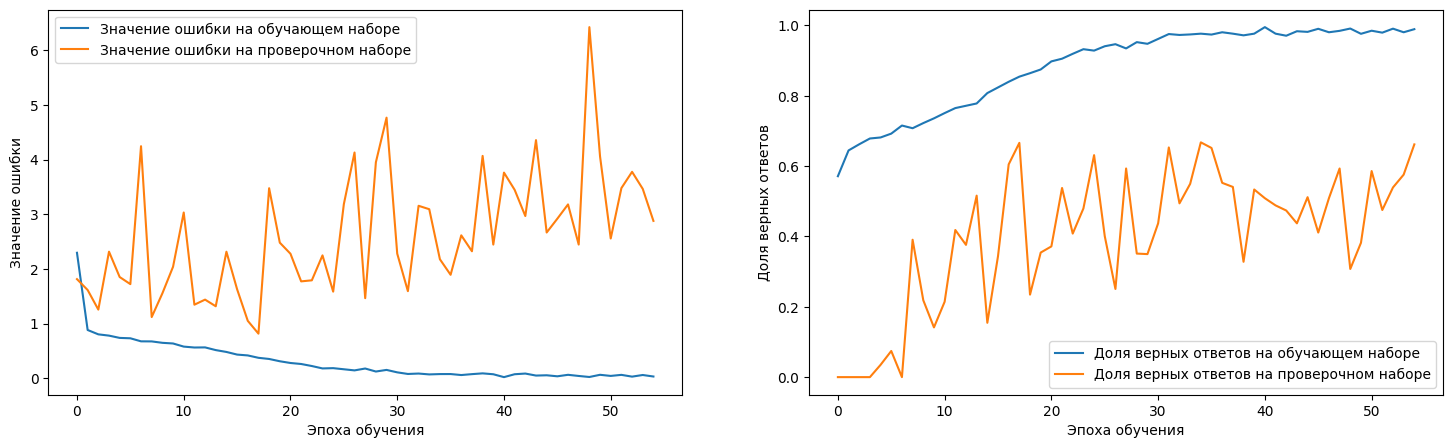

In [ ]:
# Создание полотна для рисунка
plt.figure(1, figsize=(18, 5))

# Задание первой (левой) области для построения графиков
plt.subplot(1, 2, 1)
# Отрисовка графиков 'loss' и 'val_loss' из значений словаря store_learning.history
plt.plot(store_learning.history['loss'],
         label='Значение ошибки на обучающем наборе')
plt.plot(store_learning.history['val_loss'],
         label='Значение ошибки на проверочном наборе')
# Задание подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()

# Задание второй (правой) области для построения графиков
plt.subplot(1, 2, 2)
# Отрисовка графиков 'accuracy' и 'val_accuracy' из значений словаря store_learning.history
plt.plot(store_learning.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(store_learning.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
# Задание подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

# Фиксация графиков и рисование всей картинки
plt.show()

Аугментация обучающих данных
Подключим все необходимые библиотеки:

In [ ]:
from PIL import Image, ImageEnhance       # Инструменты для работы с изображениями
import matplotlib.pyplot as plt           # Отрисовка графиков
import numpy as np                        # Работа с массивами
import random                             # Генерация случайных чисел
import math                               # Математические функции

Рассмотрим методы на примере работы с одним изображением.

Создадим экземпляр класса Image библиотеки PIL, загрузив изображение из файла при помощи функции Image.open().

В скобках укажем путь к изображению из списка data_files по номеру i.

Поместим содержимое изображения в переменную img, что откроет доступ к методам (функциям) объекта-картинки:

In [ ]:
i = 100
img  = Image.open(data_files[i])          # Открытие i-го изображения из датасета

print('Размер исходного изображения:', img.size)

Размер исходного изображения: (192, 108)


Создадим сервисную функцию для вывода картинки с помощью инструмента .imshow() из модуля plt:

In [ ]:
def show_image(img):
    plt.figure(figsize=(8, 5))            # Cоздание полотна для рисования
    plt.imshow(img)                       # Отрисовка изображения
    plt.axis('off')                       # Отключение ненужных осей
    plt.show()                            # Вывод результата

Также напишем сервисную функцию для визуального сравнения исходного изображения с измененным:

In [ ]:
def show_image_pair(img1, img2):
    # Cоздание полотна для рисования двух изображений
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Исходное изображение
    axs[0].imshow(img1)
    axs[0].axis('off')

    # Модифицированное изображение
    axs[1].imshow(img2)
    axs[1].axis('off')

    # Вывод изображений
    plt.show()

Bыведем прочитанную из файла картинку на экран:

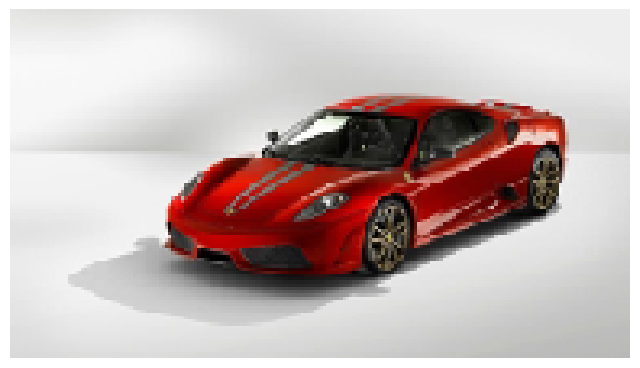

In [ ]:
show_image(img)

Изменение размера изображения: .resize()

Создадим изображение с новыми размерами функцией-методом .resize().

Она имеет следующие аргументы (символом * обозначены необязательные):

size - требуемый размер - кортеж из двух чисел; resample* - способ обработки пикселей: NEAREST, BOX, BICUBIC ...; box* - указывается масштабируемая часть изображения, если None (по умолчанию) - то все полностью; reducing_gap* - оптимизация процесса, проведение масштабирования в два этапа.

In [ ]:
img_ = img.resize((256, 128))
print('Размер преобразованного изображения:', img_.size)

Размер преобразованного изображения: (256, 128)


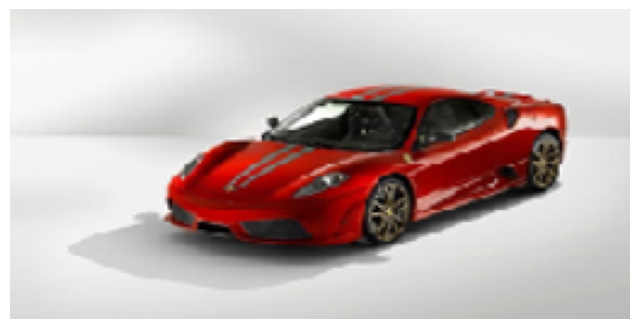

In [ ]:
# Вывод картинки
show_image(img_)

Обрезка: .сrop()

С помощью функции-метода .crop() обрезаем изображение, выделяя прямоугольную область по заданным координатам.

Функция имеет следующие аргументы:

box - кортеж из четырех значений (left, upper, right, lower) - координаты левого верхнего и правого нижнего углов рамки для обрезки.

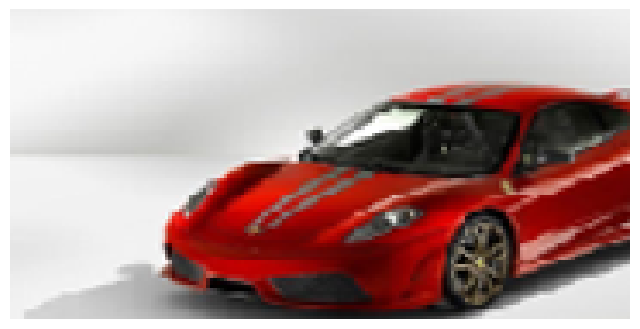

(180, 90)

In [ ]:
img_crop = img_.crop((20, 10, 200, 100))

# Вывод картинки
show_image(img_crop)

# Вывод размеров результата
img_crop.size

Напишем функцию случайной обрезки изображенияrandom_crop(). Пределы обрезки задаются в отношении к размерам картинки, а потому не должны достигать 0.5 (иначе может быть вырезано всё).



In [ ]:
def random_crop(x,                        # Подаваемое изображение
                f_x,                      # Предел обрезки справа и слева (в масштабе ширины)
                f_y                       # Предел обрезки сверху и снизу (в масштабе высоты)
                ):

    # Получение левой и правой границ обрезки
    left = x.width * random.random() * f_x
    right = x.width * (1. - random.random() * f_x) - 1.

    # Получение верхней и нижней границ обрезки
    upper = x.height * random.random() * f_y
    lower = x.height * (1. - random.random() * f_y) - 1.

    return x.crop((left, upper, right, lower))

Задавая разумные значения пределов обрезки (скажем, в пределах 0.25) и перезапуская ячейку, вы получите новые фрагменты из исходной фотографии. Обратите внимание, что всякий раз вы будете получать фрагменты разного размера:

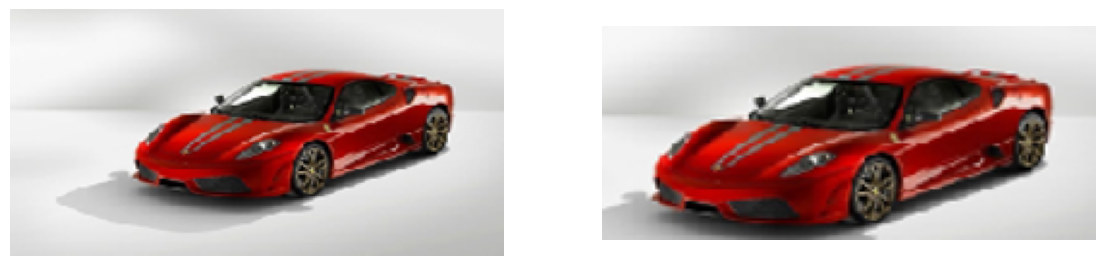

(205, 89)

In [ ]:
img_crop = random_crop(img_, 0.2, 0.2)

# Вывод картинок
show_image_pair(img_, img_crop)

# Вывод размеров результата
img_crop.size

Вращение: .rotate()

С помощью функции-метода .rotate() можно вращать картинку внутри ее границ.

Функция имеет следующие аргументы (символом * обозначены необязательные):

angle - угол поворота в градусах. Положительное число - поворот против часовой стрелки, отрицательное - по часовой стрелке; resample* - способ обработки пикселей: NEAREST, BOX, BICUBIC ...; expand* - если True, то расширяет размеры выходного изображения, чтобы повернутая картинка уместилась полностью. По умолчанию False. Предполагает вращение вокруг центра изображения и без смещения; center* - центр вращения (отсчитывается от левого верхнего угла), по умолчанию - центр изображения. Принимает кортеж из двух значений; translate* - смещение после поворота, принимает кортеж из двух значений, по умолчанию None; fillcolor* - цвет заливки пустой области, по умолчанию черный, принимает кортеж из трех значений.

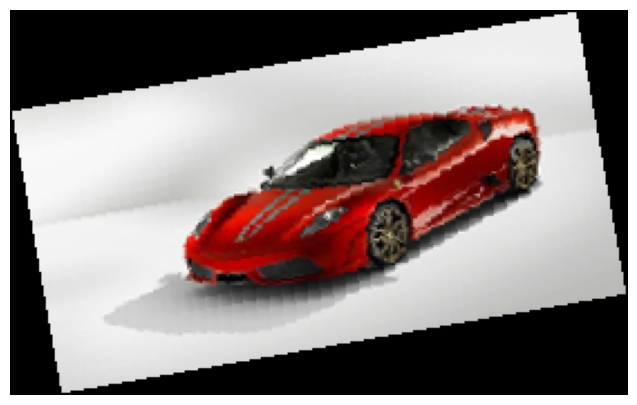

In [ ]:
angle = 10
img_rot = img_.rotate(angle, expand=True)

# Вывод картинки
show_image(img_rot)

Для создания новых обучающих изображений задавайте небольшой угол и подрезайте края. Угол должен быть случайным. Центр поворота сдвигать нет необходимости из-за обрезки краев.

Обрезка краев требуется для того, чтобы в измененную картинку не попали черные поля, образовавшиеся при повороте - их наличие может снизить точность классификации.

Нахождение прямоугольника обрезки наибольшей площади - нетривиальная математическая задача, которую вы можете попробовать решить на досуге. А здесь приводится ее решение в виде готовой функции:

In [ ]:
# Функция нахождения ширины и высоты прямоугольника наибольшей площади
# после поворота заданного прямоугольника на угол в градусах

def rotated_rect(w,                       # Ширина изображения
                 h,                       # Высота изображения
                 angle                    # Угол поворота в градусах
                 ):
    angle = math.radians(angle)
    width_is_longer = w >= h
    side_long, side_short = (w,h) if width_is_longer else (h,w)

    sin_a, cos_a = abs(math.sin(angle)), abs(math.cos(angle))

    if side_short <= 2.*sin_a*cos_a*side_long or abs(sin_a-cos_a) < 1e-10:
        x = 0.5 * side_short
        wr, hr = (x/sin_a, x/cos_a) if width_is_longer else (x/cos_a, x/sin_a)
    else:
        cos_2a = cos_a*cos_a - sin_a*sin_a
        wr, hr = (w*cos_a - h*sin_a)/cos_2a, (h*cos_a - w*sin_a)/cos_2a

    return wr, hr

Воспользуемся функцией rotated_rect() для вычисления размеров прямоугольника обрезки, а затем обрежем исходную картинку методом .crop(), располагая рамку обрезки по центру исходной картинки:

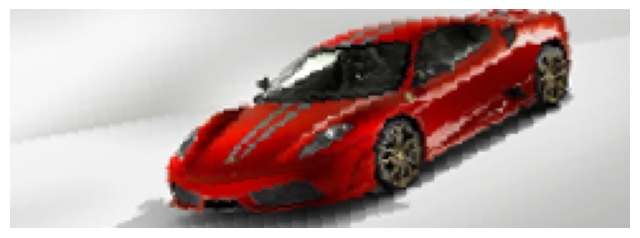

In [ ]:
# Вычисление размеров прямоугольника обрезки максимальной площади
crop_w, crop_h = rotated_rect(img_.width, img_.height, angle)

# Обрезка повернутого изображения
w, h = img_rot.size
img_rot_crop = img_rot.crop(((w - crop_w)*0.5, (h - crop_h)*0.5,
                             (w + crop_w)*0.5, (h + crop_h)*0.5))

# Вывод картинки
show_image(img_rot_crop)

Теперь напишем функцию поворота на случайный угол (в градусах) с учетом необходимой обрезки:

In [ ]:
def random_rot(x,                         # Подаваемое изображение
               ang                        # Максимальный угол поворота
               ):

    # Случайное значение угла в диапазоне [-ang, ang]
    a = random.uniform(-1., 1.) * ang

    # Вращение картинки с расширением рамки
    r = x.rotate(a, expand=True)

    # Вычисление размеров прямоугольника обрезки максимальной площади
    # для размеров исходной картинки и угла поворота в градусах
    crop_w, crop_h = rotated_rect(x.width, x.height, a)

    # Обрезка повернутого изображения и возврат результата
    w, h = r.size
    return r.crop(((w - crop_w)*0.5, (h - crop_h)*0.5,
                   (w + crop_w)*0.5, (h + crop_h)*0.5))

Посмотрите, как работает эта функция. Обратите внимание, что при каждом запуске ячейки вы получаете новые картинки одной и той же машины. Кроме того, размеры новой картинки могут меняться. Это происходит потому, что угол вращения генерируется всякий раз случайным образом и для обрезки остается разная площадь.

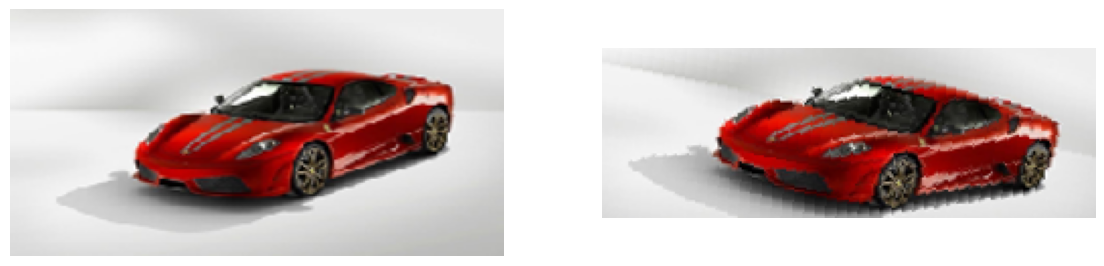

(244, 84)

In [ ]:
img_rot = random_rot(img_, 15)

# Вывод картинок
show_image_pair(img_, img_rot)

# Вывод размеров результата
img_rot.size

Отражение или поворот на угол, кратный 90 градусам: .transpose()

Функция .transpose() имеет один обязательный аргумент:

method - задает вид операции: FLIP_LEFT_RIGHT, FLIP_TOP_BOTTOM, ROTATE_90, ROTATE_180, ROTATE_270, TRANSPOSE, TRANSVERSE.

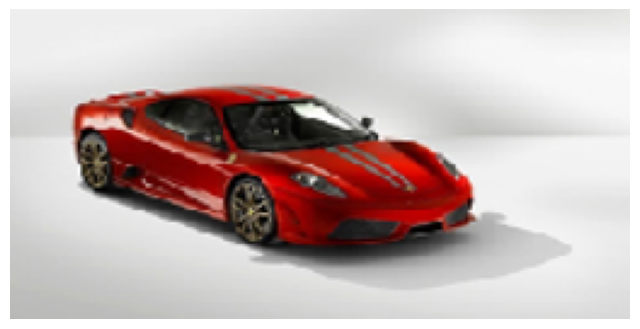

In [ ]:
img_trans = img_.transpose(Image.FLIP_LEFT_RIGHT)

# Вывод картинки
show_image(img_trans)

Оберните код по аналогии в функцию:

In [ ]:
def trans_img(x):
    return x.transpose(Image.FLIP_LEFT_RIGHT)

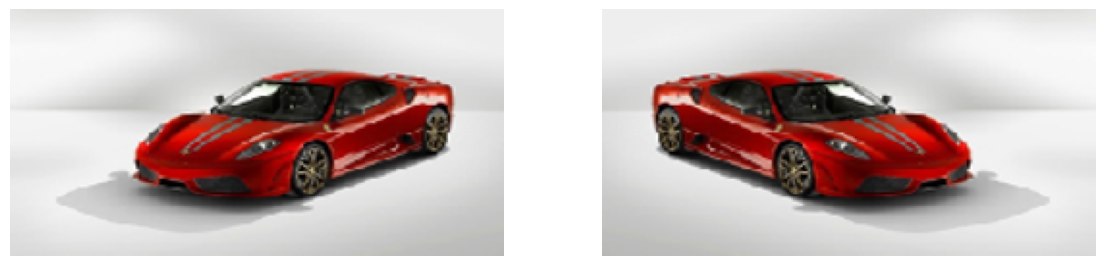

In [ ]:
img_trans = trans_img(img_)

# Вывод картинок
show_image_pair(img_, img_trans)

Изменение контрастности: Contrast

Для пополнения базы также подходят изображения с несколько измененной контрастностью.

Контрастность – это отношение яркости самого яркого участка кадра к яркости самого темного. Средняя контрастность при съемках на открытой площадке составляет 150:1, но может достигать и 1000:1.

In [ ]:
from PIL import ImageEnhance

Модуль ImageEnhance содержит дополнительные инструменты для манипуляций с изображениями. В частности, в нем есть класс Contrast, который отвечает за контрастность изображения.

Для вычисления результата необходимо создать экземпляр класса и применить функцию-метод .enhance(), указав в скобках один обязательный аргумент - коэффициент усиления, где 0. - сплошное серое изображение, а 1. - исходное изображение:

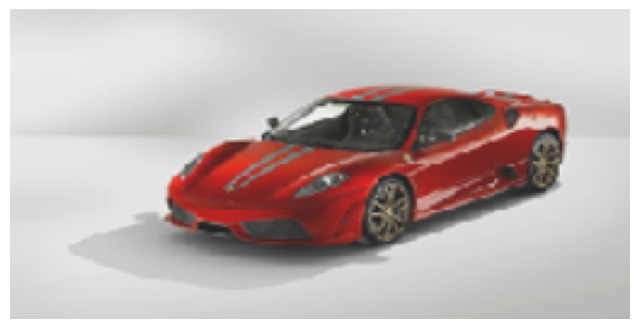

In [ ]:
enh = ImageEnhance.Contrast(img_)         # Создание экземпляра класса Contrast
img_contr = enh.enhance(0.8)              # Изменение коэффициента контраста

# Вывод картинки
show_image(img_contr)

берните код по аналогии в функцию. В качестве параметра уровня (level) используется максимальное отклонение коэффициента контраста от исходного изображения. Тогда случайный коэффициент контраста будет находиться в пределах от 1. - level до 1. + level, уменьшая или увеличивая контрастность изображения по сравнению с исходным.

In [ ]:
def random_contrast(x,                    # Подаваемое изображение
                    level                 # Максимальное отклонение коэффициента контраста от нормы - число от 0. до 1.
                    ):

    enh = ImageEnhance.Contrast(x)        # Создание экземпляра класса Contrast
    factor = random.uniform(1. - level,
                            1. + level)   # Cлучайный коэффициент контраста из указанного интервала

    return enh.enhance(factor)            # Изменение коэффициента контраста

Опробуйте работу функции несколько раз:

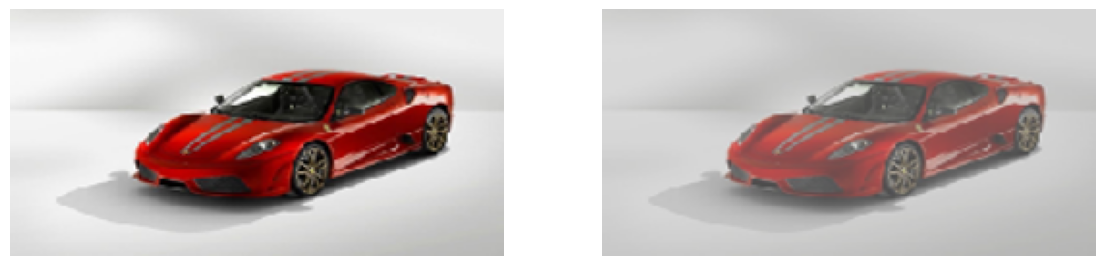

In [ ]:
img_contr = random_contrast(img_, 0.8)

# Вывод картинок
show_image_pair(img_, img_contr)

Изменение яркости: Brightness

Также в модуле ImageEnhance имеется класс Brightness, который отвечает за яркость изображения.

Для вычисления результата необходимо создать экземпляр класса и применить функцию-метод .enhance(), указав в скобках один обязательный аргумент - коэффициент усиления, где 0. - черное изображение, а 1. - исходное изображение:

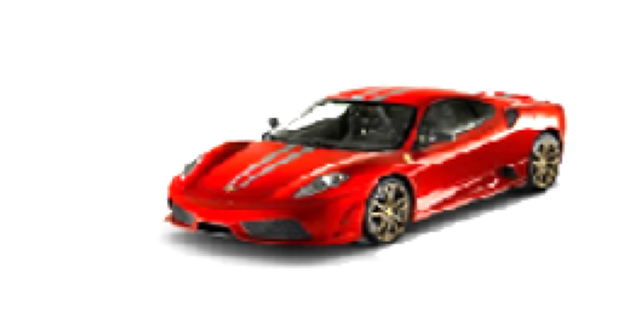

In [ ]:
enh = ImageEnhance.Brightness(img_)
img_bright = enh.enhance(1.5)

# Вывод картинки
show_image(img_bright)

Оберните код по аналогии в функцию. Похоже на предыдущий код: в качестве параметра уровня (level) используется максимальное отклонение коэффициента яркости от исходного изображения.

In [ ]:
def random_brightness(x,                  # Подаваемое изображение
                      level               # Максимальное отклонение коэффициента яркости от нормы - число от 0. до 1.
                      ):

    enh = ImageEnhance.Brightness(x)      # Создание экземпляра класса Brightness
    factor = random.uniform(1. - level,
                            1. + level)   # Cлучайный коэффициент контраста из указанного интервала

    return enh.enhance(factor)            # Изменение коэффициента яркости

Опробуйте работу функции несколько раз:

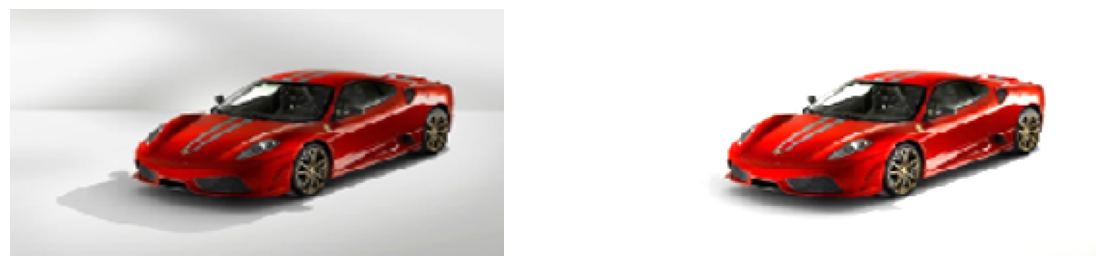

In [ ]:
img_bright = random_brightness(img_, 0.4)

# Вывод картинок
show_image_pair(img_, img_bright)

Применение всех модификаций изображения

Теперь попробуем применить к изображению сразу несколько случайных изменений с помощью разработанных функций. Применим их одно за другим:

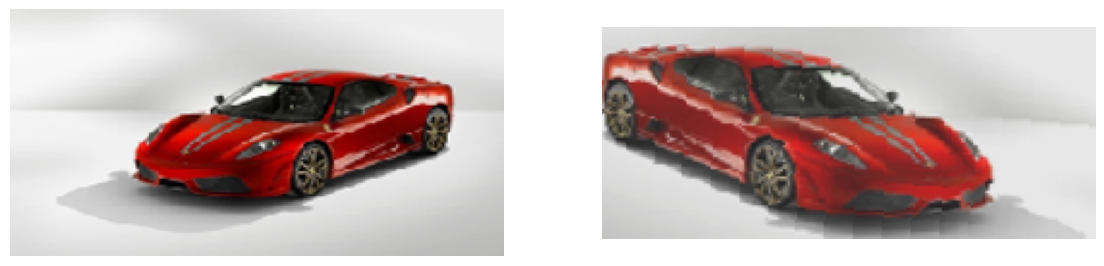

In [ ]:
img_new = img_

# Последовательное применение случайных изменений исходного изображения
img_new = random_rot(img_new, 5)
img_new = random_crop(img_new, 0.1, 0.3)
img_new = trans_img(img_new)
img_new = random_brightness(img_new, 0.3)
img_new = random_contrast(img_new, 0.3)

# Вывод картинок
show_image_pair(img_, img_new)

Вновь запуская ячейку, вы каждый раз получите новое изображение, прошедшее серию случайных модификаций в определенном выше порядке.

Случайное применение изменений изображения

Чтобы получить случайный набор изменений, отобранных из разработанных выше функций, создайте список изменений.

А затем примените эти изменения, выбирая их из списка в случайном порядке (и количестве):

In [ ]:
x = img_

mod_oper = [random_rot(x, ang=5),
            random_crop(x, f_x=0.2, f_y=0.2),
            trans_img(x),
            random_contrast(x, level=0.5),
            random_brightness(x, level=0.5)]

mod_name = ['случайный поворот',
            'случайная обрезка',
            'зеркальное отражение',
            'случайная контрастность',
            'случайная яркость']

Примените выбранное изменение картинки по случайному индексу: random.randrange(len(mod_oper)) из списка mod_oper.

случайный поворот


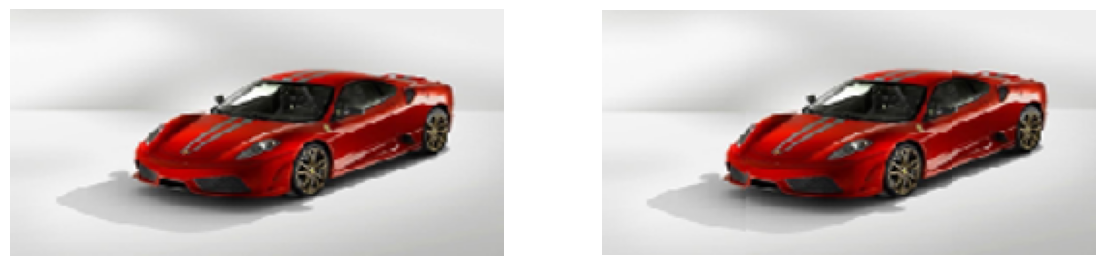

In [ ]:
idx = random.randrange(len(mod_oper))
img_new = mod_oper[idx]
print(mod_name[idx])

# Вывод картинок
show_image_pair(img_, img_new)

Добавьте цикл, который применит случайно отобранные изменения в случайном количестве.

Количество изменений 5: [1, 0, 3, 4, 2]
случайная обрезка
случайный поворот
случайная контрастность
случайная яркость
зеркальное отражение


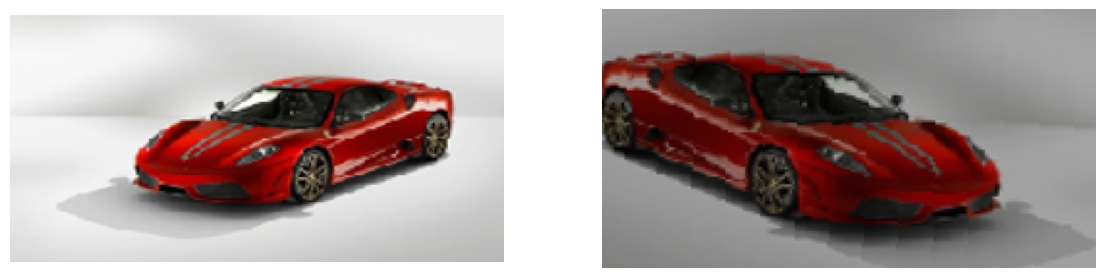

In [ ]:
# Начальное изображение
x = img_
# Cлучайное количество изменений из списка; минимум одно изменение
mod_count = random.randrange(len(mod_oper)) + 1

# Случайный отбор индексов изменений в количестве mod_count без повторений
mod_list = random.sample(range(len(mod_oper)), mod_count)

print(f'Количество изменений {mod_count}: {mod_list}')

for mod_index in mod_list:
    # Генерация изменений изображения
    mod_oper = [random_rot(x, ang=5),
                random_crop(x, f_x=0.1, f_y=0.1),
                trans_img(x),
                random_contrast(x, level=0.5),
                random_brightness(x, level=0.5)]

    # Случайный выбор изменения и печать его названия
    x = mod_oper[mod_index]
    print(mod_name[mod_index])


# Вывод картинок
show_image_pair(img_, x)

Над картинками выводится список последовательно примененных модификаций в случайном порядке.

У приведенного выше кода есть недостаток - сначала вычисляются все виды преобразований исходной картинки, а уже потом из этих результатов выбирается один случайный, все остальные отбрасываются. Это, конечно, нерационально по отношению к ценному вычислительному ресурсу компьютера, ситуацию необходимо исправить. Далее показан пример, как это сделать. В исправленной версии изменение картинки производится после случайного выбора функции изменения.

Сборка общей функции аугментации

Теперь осталось собрать отдельные функции изменений в одну общую функцию случайной аугментации изображений.

In [ ]:
def augment_image(img,                    # Изображение для аугментации
                  ang=8,                  # Максимальный угол поворота
                  f_x=0.15,               # Максимальная подрезка по ширине
                  f_y=0.15,               # Максимальная подрезка по высоте
                  level_contr=0.3,        # Максимальное отклонение коэффициента контраста от нормы
                  level_brght=0.3):       # Максимальное отклонение коэффициента яркости от нормы


    # Функция нахождения ширины и высоты прямоугольника наибольшей площади
    # после поворота заданного прямоугольника на угол в градусах

    def rotated_rect(w, h, angle):
        angle = math.radians(angle)
        width_is_longer = w >= h
        side_long, side_short = (w,h) if width_is_longer else (h,w)

        sin_a, cos_a = abs(math.sin(angle)), abs(math.cos(angle))
        if side_short <= 2.*sin_a*cos_a*side_long or abs(sin_a-cos_a) < 1e-10:
            x = 0.5 * side_short
            wr, hr = (x/sin_a, x/cos_a) if width_is_longer else (x/cos_a, x/sin_a)
        else:
            cos_2a = cos_a*cos_a - sin_a*sin_a
            wr, hr = (w*cos_a - h*sin_a)/cos_2a, (h*cos_a - w*sin_a)/cos_2a

        return wr, hr


    # Функция случайной обрезки

    def random_crop(x,                    # Подаваемое изображение
                    f_x=f_x,              # Предел обрезки справа и слева (в масштабе ширины)
                    f_y=f_x               # Предел обрезки сверху и снизу (в масштабе высоты)
                    ):

        # Получение левой и правой границ обрезки
        left = x.width * random.random() * f_x
        right = x.width * (1. - random.random() * f_x) - 1.

        # Получение верхней и нижней границ обрезки
        upper = x.height * random.random() * f_y
        lower = x.height * (1. - random.random() * f_y) - 1.

        return x.crop((left, upper, right, lower))


    # Функция случайного поворота

    def random_rot(x,                     # Подаваемое изображение
                   ang=ang                # Максимальный угол поворота
                   ):

        # Случайное значение угла в диапазоне [-ang, ang]
        a = random.uniform(-1., 1.) * ang

        # Вращение картинки с расширением рамки
        r = x.rotate(a, expand=True)

        # Вычисление размеров прямоугольника обрезки максимальной площади
        # для размеров исходной картинки и угла поворота в градусах
        crop_w, crop_h = rotated_rect(x.width, x.height, a)

        # Обрезка повернутого изображения и возврат результата
        w, h = r.size
        return r.crop(((w - crop_w)*0.5, (h - crop_h)*0.5,
                       (w + crop_w)*0.5, (h + crop_h)*0.5))


    # Функция отражения

    def trans_img(x):
        return x.transpose(Image.FLIP_LEFT_RIGHT)

 # Функция случайного изменения контрастности

    def random_contrast(x,                   # Подаваемое изображение
                        level=level_contr    # Максимальное отклонение коэффициента контраста от нормы - число от 0. до 1.
                        ):

        enh = ImageEnhance.Contrast(x)       # Создание экземпляра класса Contrast
        factor = random.uniform(1. - level,
                                1. + level)  # Cлучайный коэффициент контраста из указанного интервала

        return enh.enhance(factor)           # Изменение коэффициента контраста



    # Функция случайного изменения яркости

    def random_brightness(x,                 # Подаваемое изображение
                        level=level_brght    # Максимальное отклонение коэффициента яркости от нормы - число от 0. до 1.
                        ):

        enh = ImageEnhance.Brightness(x)     # Создание экземпляра класса Brightness
        factor = random.uniform(1. - level,
                                1. + level)  # Cлучайный коэффициент контраста из указанного интервала

        return enh.enhance(factor)           # Изменение коэффициента яркости


    # Тело основной функции

    # Cоздание списка модификаций
    mod_oper = [random_rot,
                random_crop,
                trans_img,
                random_contrast,
                random_brightness]

    # Cлучайное количество изменений из списка; минимум одно изменение
    mod_count = random.randrange(len(mod_oper) + 1)

    # Случайный отбор индексов изменений в количестве mod_count без повторений
    mod_list = random.sample(range(len(mod_oper)), mod_count)

    # Применение модификаций по индексам из mod_list
    for mod_index in mod_list:
        img = mod_oper[mod_index](img)

    # Возврат результата
    return img

При запуске будет происходить применение случайного количества методов аугментации в случайном порядке.

Опробуйте функцию несколько раз, перезапуская ячейку:

In [ ]:
# Применение аугментаций
img_new = augment_image(img_)

# Вывод картинок
show_image_pair(img_, img_new)

Посмотрим на несколько вариантов аугментации одной картинки, запуская вычисления в цикле:

In [ ]:
for _ in range(20):
    # Применение аугментаций
    img_new = augment_image(img_)

    # Вывод картинок
    show_image_pair(img_, img_new)

Вы получили мощное средство расширения обучающего набора данных.

Теперь можно управляемо увеличивать объем набора, добавляя в него любое нужное количество аугментированных изображений.